In [2]:
# 拿到所有的名词和所有的词，选择重要名词
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from paddlenlp.transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import paddle
paddle.set_device('gpu')
plt.rcParams['axes.unicode_minus']=False
all_n=[]
all=[]
all_n_vec=[]
all_vec=[]
with open(r'1000条评论_名词_去重.tsv','r',encoding='utf-8') as f:
    for line in f.readlines():
        all_n.append(line.strip())
with open(r'1000条评论_预处理结果.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        all.append(line.strip())
class Mybert:
    def __init__(self):
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    def get(self,text):
        tokenized_text = self.tokenizer.tokenize(text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = paddle.to_tensor([indexed_tokens])
        self.bert.eval()
        with paddle.no_grad():
            # 放到gpu运算
            outputs = self.bert(tokens_tensor.cuda())
        return paddle.mean(outputs[2][0],axis=1).numpy().tolist()[0]
mybert=Mybert()

def rbf_attention(vec, memory, gamma):
    z = rbf_kernel(vec, memory, gamma)
    s = z.sum()
    if s == 0:
        return np.ones((1, len(vec))) / len(vec)
    return (z.sum(1) / s)[None, :]
all_n_vec=np.array([mybert.get(each) for each in all_n]).astype(np.float32)
all_vec=np.array([mybert.get(each) for each in all]).astype(np.float32)
print('备选方面词',all_n_vec.shape,sep='\n')
print('文档嵌入',all_vec.shape,sep='\n')

[2023-09-23 21:14:28,258] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese.pdparams
[2023-09-23 21:14:35,366] [    INFO] - Weights from pretrained model not used in BertModel: ['cls.predictions.decoder_weight', 'cls.predictions.decoder_bias', 'cls.predictions.transform.weight', 'cls.predictions.transform.bias', 'cls.predictions.layer_norm.weight', 'cls.predictions.layer_norm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
[2023-09-23 21:14:35,863] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese-vocab.txt
[2023-09-23 21:14:35,884] [    INFO] - tokenizer config file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\tokenizer_config.json
[2023-09-23 21:14:35,885] [    INFO] - Special tokens file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\special_tokens_map.json


备选方面词
(5963, 768)
文档嵌入
(1000, 768)


In [0]:
# 确定gamma
def draw_2d(gama):
    att_ = sorted(enumerate(rbf_attention(all_n_vec,all_vec,gama)[0]), key=lambda x: x[1], reverse=True)
    index_of_att=[each[0] for each in att_]
    return [att_[i][1] for i in range(len(index_of_att))]
# 归一化后的方差
RESULT=[]
le=[i for i in np.arange(0.001,0.02,0.001)]
for g in le:
    result=draw_2d(g)
    # 归一化
    result=[(each-np.min(result))/(np.max(result)-np.min(result)) for each in result]
    # 方差
    RESULT.append(np.var(np.array(result)))
print(RESULT)
gama=le[RESULT.index(max(RESULT))]
print('gamma=',gama)
plt.plot(le,RESULT)
plt.xticks(fontsize=15,fontfamily='STsong')
plt.yticks(fontsize=15,fontfamily='STsong')
plt.xlabel('γ',fontsize=20,fontfamily='STsong')
plt.ylabel('方差',fontsize=20,fontfamily='STsong')

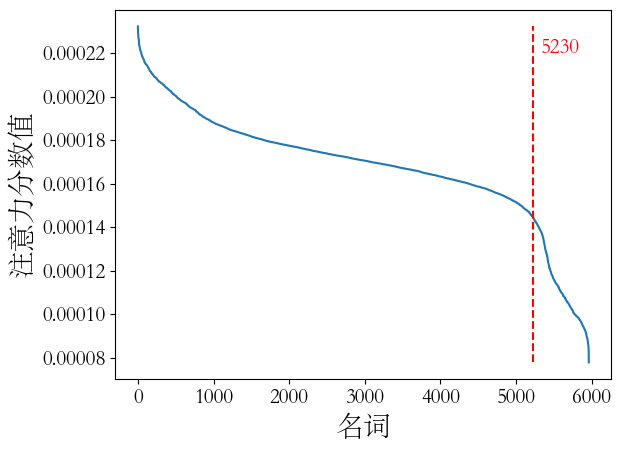

In [12]:
# 注意力分数值
plt.figure()
att_ = sorted(enumerate(rbf_attention(all_n_vec,all_vec,gama)[0]), key=lambda x: x[1], reverse=True)
index_of_att=[each[0] for each in att_]
plt.plot([att_[i][1] for i in range(len(index_of_att))])
plt.vlines(5230,min([att_[i][1] for i in range(len(index_of_att))]),max([att_[i][1] for i in range(len(index_of_att))]),linestyles='--',colors='r')
plt.annotate('5230',xy=(5230,0.00022),xytext=(5230+100,0.00022),fontsize=15,fontfamily='STsong',color='r')

plt.xticks(fontsize=15,fontfamily='STsong')
plt.yticks(fontsize=15,fontfamily='STsong')
plt.xlabel('名词',fontsize=20,fontfamily='STsong')
plt.ylabel('注意力分数值',fontsize=20,fontfamily='STsong')

# 保存结果
with open('所有词的注意力分数值.tsv','w',encoding='utf-8') as f:
    for i in range(len(att_)):
        f.write(all_n[index_of_att[i]]+'\t'+str(att_[i][1])+'\n')

In [13]:
# 保存结果
with open('CAT法抽取到的方面词.tsv','w',encoding='utf-8') as f:
    for i in range(5230):
        f.write(all_n[index_of_att[i]]+'\n')